## Lab Title 2: Generalization, Overfitting, and Similarity
### Objective: Learn how to explore data (EDA), understand why models fail (overfitting), and master similarity-based learning (k-NN) with proper data scaling.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from matplotlib.colors import ListedColormap

# Setup for nice plots
sns.set_theme(style="whitegrid")

### Part 1: Exploratory Data Analysis (EDA)

Goal: Understand the data distribution and identify why "blind" modeling is dangerous.

#### 1.1 Loading the Data We will load the dataset and immediately drop missing values to keep this lab focused on modeling.

In [2]:
sns.load_dataset('penguins')

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female


In [3]:
df= sns.load_dataset('penguins')

In [4]:
#Inspect the data to make sure it loaded successfully
print(df.head())

  species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen            39.1           18.7              181.0   
1  Adelie  Torgersen            39.5           17.4              186.0   
2  Adelie  Torgersen            40.3           18.0              195.0   
3  Adelie  Torgersen             NaN            NaN                NaN   
4  Adelie  Torgersen            36.7           19.3              193.0   

   body_mass_g     sex  
0       3750.0    Male  
1       3800.0  Female  
2       3250.0  Female  
3          NaN     NaN  
4       3450.0  Female  


In [5]:
print (f"Missing values before drop: \n{df.isnull().sum()}")
df = df. dropna()

df['species_code']= df['species']. astype('category'). cat.codes

Missing values before drop: 
species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64


,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,species_code
count,333.000000,333.000000,333.000000,333.000000,333.000000
mean,43.992793,17.164865,200.966967,4207.057057,0.918919
std,5.468668,1.969235,14.015765,805.215802,0.889718
min,32.100000,13.100000,172.000000,2700.000000,0.000000
25%,39.500000,15.600000,190.000000,3550.000000,0.000000
50%,44.500000,17.300000,197.000000,4050.000000,1.000000
75%,48.600000,18.700000,213.000000,4775.000000,2.000000
max,59.600000,21.500000,231.000000,6300.000000,2.000000


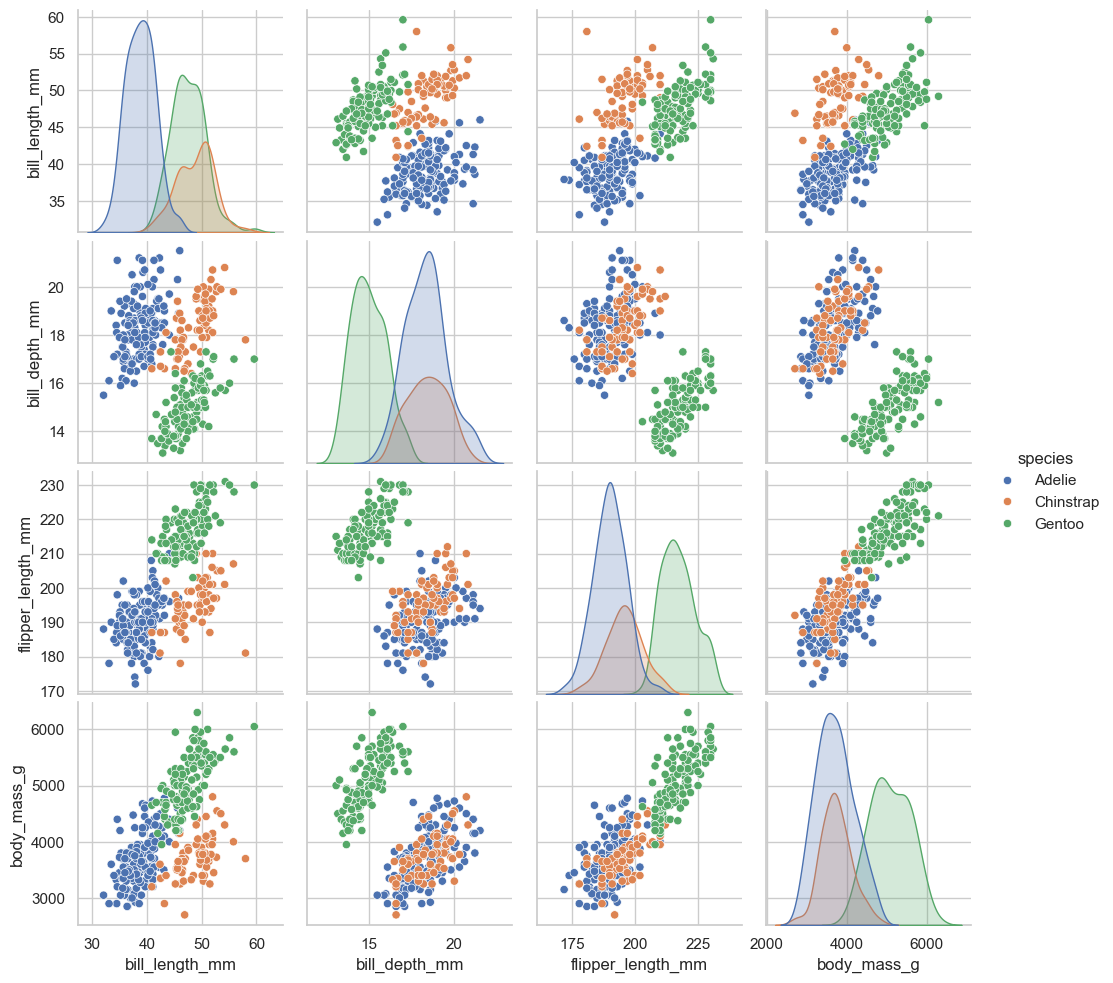

In [6]:
display(df.describe())

sns.pairplot(df, hue='species', vars=['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g'])
plt.show()

Strong correlations  (very strong positive correlations)

can be observed between flipper_length_mm and body_mass_g.

EDA (Exploaratory Data Analysis)

This pairplot visualizes the relationships between four numerical features in the penguins dataset. The diagonal shows the distribution of each variable per species, while off-diagonal plots show pairwise relationships. We observe clear clustering by species, especially Gentoo penguins which are heavier and have longer flippers. There are strong positive correlations between flipper length and body mass. These patterns indicate that the features are highly discriminative and suitable for classification tasks.


This pairplot shows that penguin species can be clearly distinguished using body measurements, with strong correlations between flipper length, body mass, and bill dimensions.

### 1.2 The "Detective" Work Instructor Note:

"Look at the histogram for Body Mass vs. Bill Length. If we calculate the 'distance' between two penguins, which feature matters more? The one with numbers like 5000, or the one with numbers like 40?"

### Part 2: The Overfitting Trap (Decision Trees)
Goal: Visualize how "complex" models just memorize data (Overfitting) instead of learning rules.

To make the plots clear, we will use only two features: bill_length_mm and bill_depth_mm.

### 2.1 The "Golden Rule" Split Reference Slide 30: "The test data must never influence the training phase".

In [8]:
x = df[['bill_length_mm', 'bill_depth_mm']].values
y= df['species_code'].values

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

print(f"Training shapes: {X_train.shape}")
print(f"Test set size: {X_test.shape}")


Training shapes: (266, 2)
Test set size: (67, 2)


### 2.2 Helper Function: Plotting Boundaries

In [9]:
def plot_decision_boundary(model, X, y,title= "Decision Boundary"):  #parameter #model, features, labels, title
    #Create a meshgrid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    
    #Predict
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])  #Flatten values #2d to 1d
    Z = Z.reshape(xx.shape) #Reshape back to 2d convert to matrix form

    #Plot
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap=ListedColormap(('#FFAAAA', '#AAFFAA', '#AAAAFF')))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, edgecolors='k',cmap=ListedColormap(('#FF0000', '#00FF00', '#0000FF')))
    plt.title(title)
    plt.xlabel('Bill Length (mm)')
    plt.ylabel('Bill Depth (mm)')
    plt.show()

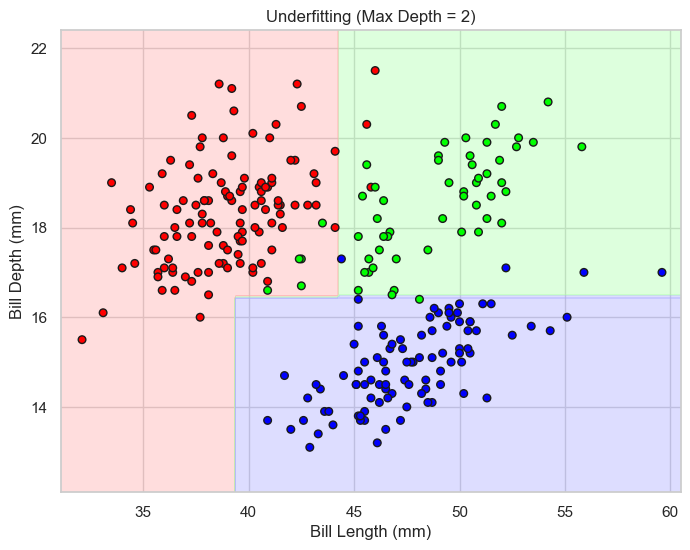

Simple Tree Test Accuracy: 0.93


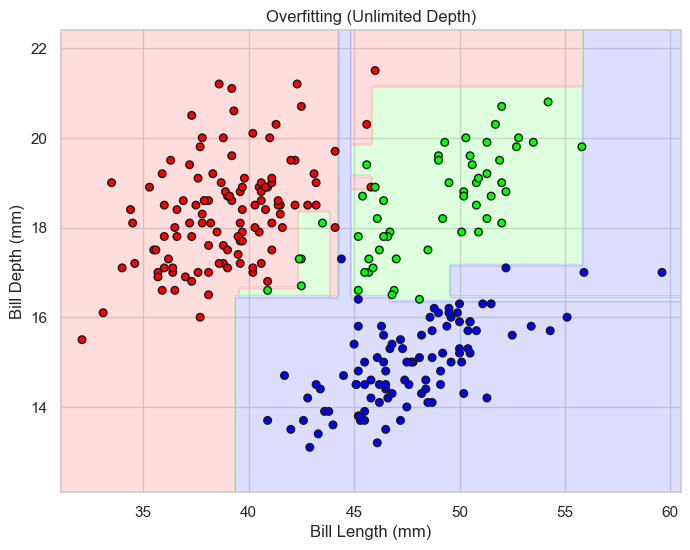

Complex Tree Test Accuracy: 0.94


In [10]:
# Model 1: Underfitting (Too Simple) - Slide 24 [cite: 531]
tree_simple = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_simple.fit(X_train, y_train)
plot_decision_boundary(tree_simple, X_train, y_train, "Underfitting (Max Depth = 2)")
print(f"Simple Tree Test Accuracy: {tree_simple.score(X_test, y_test):.2f}")

# Model 2: Overfitting (Memorization) - Slide 23 [cite: 513]
tree_complex = DecisionTreeClassifier(max_depth=None, random_state=42)
tree_complex.fit(X_train, y_train)
plot_decision_boundary(tree_complex, X_train, y_train, "Overfitting (Unlimited Depth)")
print(f"Complex Tree Test Accuracy: {tree_complex.score(X_test, y_test):.2f}")


Big Picture First

You are training two Decision Tree models:

A very simple tree → shows UNDERFITTING

A very complex tree → shows OVERFITTING

And you:

Train them on training data

Draw their decision boundaries

Test their accuracy on test data

🌱 Part 1 — Underfitting Model (Too Simple)
tree_simple = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_simple.fit(X_train, y_train)
plot_decision_boundary(tree_simple, X_train, y_train, "Underfitting (Max Depth = 2)")
print(f"Simple Tree Test Accuracy: {tree_simple.score(X_test, y_test):.2f}")

What does this mean?
✅ DecisionTreeClassifier(max_depth=2)

You are limiting the tree depth to only 2 levels

This means:

The tree can only make very few decisions

So the model is:

❗ Too simple to learn the real pattern in the data

✅ fit(X_train, y_train)

The model learns from training data

✅ plot_decision_boundary(...)

This draws the classification regions

You will see:

Very rough, simple boundaries

Many points will be misclassified

✅ tree_simple.score(X_test, y_test)

This tests the model on unseen data

Because the model is too simple:

❌ Accuracy will be low

🧠 This is called UNDERFITTING

The model is too simple → cannot capture the real pattern → performs badly on both training and test data.

🌳 Part 2 — Overfitting Model (Too Complex)
tree_complex = DecisionTreeClassifier(max_depth=None, random_state=42)
tree_complex.fit(X_train, y_train)
plot_decision_boundary(tree_complex, X_train, y_train, "Overfitting (Unlimited Depth)")
print(f"Complex Tree Test Accuracy: {tree_complex.score(X_test, y_test):.2f}")

What does this mean?
✅ max_depth=None

This means:

The tree can grow as deep as it wants

So the tree will:

Keep splitting until:

It almost memorizes the training data

✅ What happens?

On training data: almost 100% accurate

But on test data:

❌ Accuracy often becomes worse because the model learned noise, not real patterns

✅ The decision boundary will look:

Very curvy

Very complicated

Almost passing through every single point

🧠 This is called OVERFITTING

The model learns the training data too perfectly, including noise → performs badly on new data.

⚖️ The Core ML Concept
Model Type	What Happens	Training Accuracy	Test Accuracy
Underfitting	Too simple	Low	Low
Overfitting	Too complex	Very high	Lower
Good Fit	Balanced	High	High
🎯 Why Decision Trees are perfect for this demo

Because:

You can control complexity using max_depth

Small depth = simple model

Large depth = complex model

🧪 What you are demonstrating in this code

You are visually and numerically showing the Bias–Variance Tradeoff

Underfitting = High Bias (learning less > random > loss of data > wrong cluster

Overfitting = High Variance (LEARNING TOO MUCH will be ok> observe boundary/ uneven bondary)


The first model limits the tree depth to 2, making it too simple and unable to capture the data structure, resulting in underfitting. The second model allows unlimited depth, causing it to memorize the training data and learn noise, resulting in overfitting. This code demonstrates the trade-off between model simplicity and generalization.


🧠 What it means:

The model is too simple to capture the real structure of the data.

You can see:

Many red points inside green/blue areas

Many blue points inside wrong regions

The boundaries are too rough and too straight

❌ Problem:

The model cannot separate the classes properly → HIGH BIAS

So:

❌ Performs badly on training data

❌ Also performs badly on test data

This is UNDERFITTING.


🧠 What it means:

The model is memorizing the training data instead of learning general patterns.

You can see:

Almost every point is in its own correct little region

The model creates weird, unnatural shapes just to classify training points correctly

❌ Problem:

It learns noise and outliers → HIGH VARIANCE

So:

✅ Very high training accuracy

❌ Worse test accuracy (poor generalization)

This is OVERFITTING.


📝 Exam-ready short answer

The first model limits the tree depth to 2, making it too simple and unable to capture the data structure, resulting in underfitting. The second model allows unlimited depth, causing it to memorize the training data and learn noise, resulting in overfitting. This code demonstrates the trade-off between model simplicity and generalization.

🧠 One-line intuition

❌ Underfitting = too dumb
❌ Overfitting = too obsessed
✅ Good model = learns patterns, not noise

If you want, I can:

Explain what the decision boundary plot means

Or explain bias–variance tradeoff

Or turn this into presentation-ready slides explanation


max-depth (lose generalisation)

### 2.3 Activity: Compare Underfitting vs. Overfitting Run two models: one simple (max_depth=2) and one unlimited (max_depth=None).

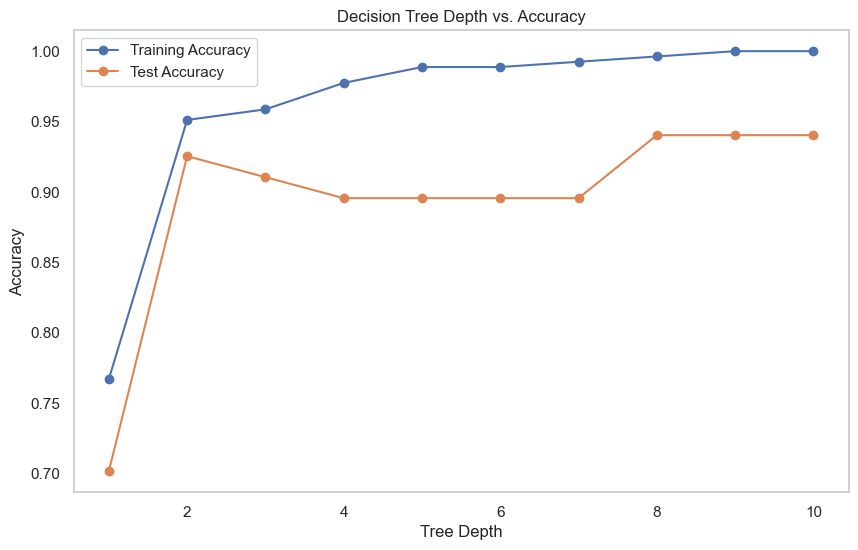

In [11]:
#Cross Validation to find optimal depth
depths = range(1, 11)
train_scores = []
test_scores = []


for depth in depths:
    tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
    tree.fit(X_train, y_train)
    train_scores.append(tree.score(X_train, y_train))
    test_scores.append(tree.score(X_test, y_test))
#Plotting training and test scores
plt.figure(figsize=(10, 6))
plt.plot(depths, train_scores, label='Training Accuracy', marker='o')
plt.plot(depths, test_scores, label='Test Accuracy', marker='o')    
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.title('Decision Tree Depth vs. Accuracy')
plt.legend()
plt.grid()  
plt.show()  
    

The optimal max depth is: 7
Cross-Validated Accuracy at this depth: 0.94


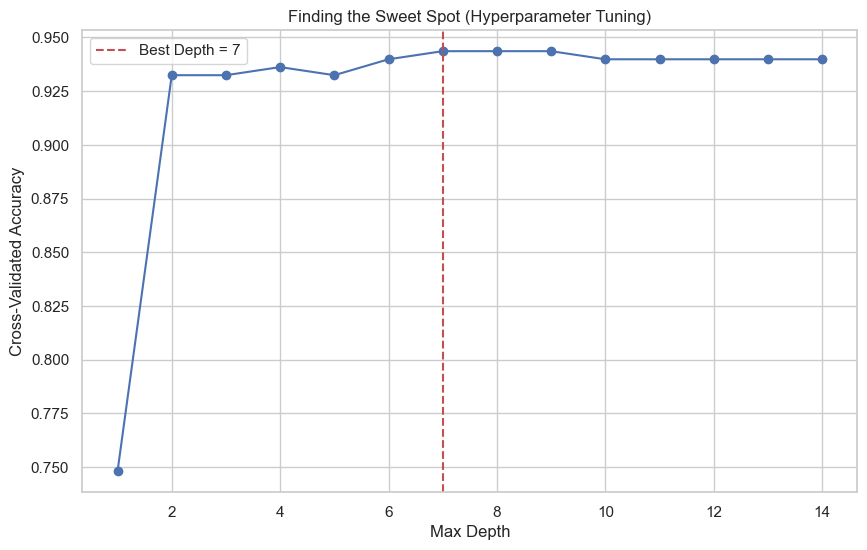

In [13]:
# Define the range of depths we want to test
depth_range = range(1, 15)
cv_scores_mean = []

# 1. Loop through depths and calculate cross-validation score
for d in depth_range:
    clf = DecisionTreeClassifier(max_depth=d, random_state=42)
    
    # We use X_train and y_train (Golden Rule: Don't touch Test data!)
    # cv=5 means it trains on 4 chunks and validates on the 5th, 5 times.
    scores = cross_val_score(clf, X_train, y_train, cv=5)
    
    # Store the average of the 5 scores
    cv_scores_mean.append(scores.mean())

# 2. Find the best depth programmatically
best_depth = depth_range[np.argmax(cv_scores_mean)]
best_score = max(cv_scores_mean)

print(f"The optimal max depth is: {best_depth}")
print(f"Cross-Validated Accuracy at this depth: {best_score:.2f}")

# 3. Plot the result
plt.figure(figsize=(10, 6))
plt.plot(depth_range, cv_scores_mean, marker='o', linestyle='-', color='b')
plt.axvline(x=best_depth, color='r', linestyle='--', label=f'Best Depth = {best_depth}')
plt.xlabel("Max Depth")
plt.ylabel("Cross-Validated Accuracy")
plt.title("Finding the Sweet Spot (Hyperparameter Tuning)")
plt.legend()
plt.grid(True)
plt.show()


"Notice the unlimited tree creates tiny 'islands' of color around single dots? That is the model memorizing noise."

### 2.4 The Complexity Tradeoff Curve

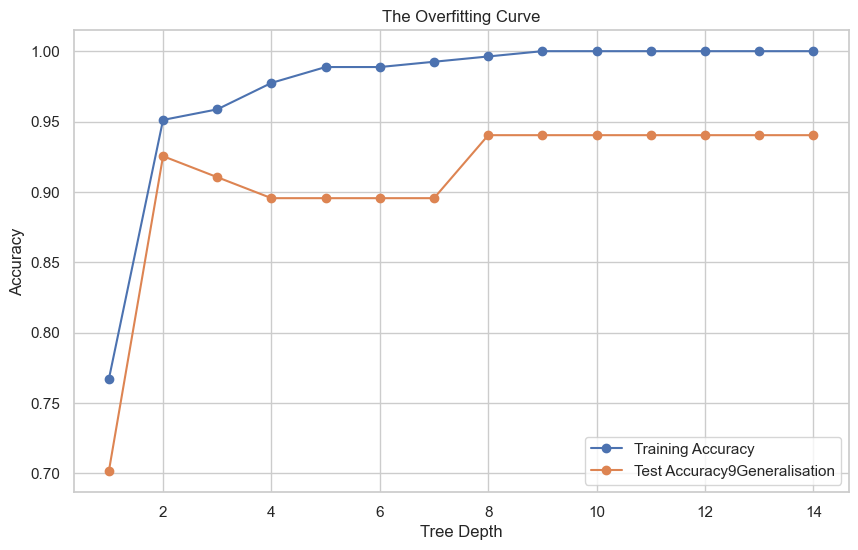

In [ ]:
depths = range(1, 15)
train_scores = []
test_scores = []

for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, random_state=42)
    clf.fit(X_train, y_train)
    train_scores.append(clf.score(X_train, y_train))
    test_scores.append(clf.score(X_test, y_test))

plt.figure(figsize=(10, 6))
plt.plot(depths, train_scores, label='Training Accuracy', marker='o')
plt.plot(depths, test_scores, label='Test Accuracy Generalisation', marker='o')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.title('The Overfitting Curve')
plt.show()

The graph shows training and test accuracy as a function of decision tree depth. For small depths, both accuracies are low, indicating underfitting. As depth increases, both accuracies improve, showing better learning of the data structure. Beyond a certain depth (around 8), training accuracy reaches 100% while test accuracy no longer improves, indicating overfitting. Therefore, a tree depth of approximately 8 provides the best balance between model complexity and generalization.

## Part 3: Similarity & Scaling (k-NN)
Goal: Show that "Distance" is broken if features have different scales.

We will switch to body_mass_g vs bill_length_mm to maximize the scaling problem.

### 3.1 The "Unscaled" Failure
Train k-NN on raw data.

### 3.2 The Fix: Normalization


Apply StandardScaler to make unit variance ($\mu=0, \sigma=1$).

### Part 4: Cross-Validation
Goal: Prove that a single Train/Test split might be "lucky" or "unlucky.

Closing Discussion:

- Why did the Decision Tree reach 100% training accuracy but perform worse on testing? 

- Why did scaling the data improve k-NN but likely wouldn't change the Decision Tree much? (Hint: Trees look at one feature at a time; k-NN combines them into a distance).

- "We used StandardScaler for k-NN. What happens if we use MinMaxScaler instead? Does the accuracy change? Why?" (This forces them to look up documentation and experiment).

### Part 5: The Model Showdown (Decision Tree vs. k-NN)
Goal: Compare the two models on the exact same task (bill_length vs body_mass) and visualize how they think differently.